## One Host SEIR + One Vector SEI model in Julia

*Author*: Carl A. B. Pearson  
*Date*: 2 OCT 2018

First, create a system of ODEs conforming to the required signature:

In [1]:
function F(du,u,p,t)
    S_H, E_H, I_H, R_H, S_V, E_V, I_V = u
    
    # host dynamics
    host_infection = (p.β*S_H*I_V)/p.N_H
    host_mortality = p.μ_H .* u[1:4] # include S_H, so easier to remove mortality
    host_births = sum(host_mortality)
    host_progression = p.σ_H*E_H
    recovery = p.λ*I_H
    
    du[1] = -host_infection + host_births
    du[2] = host_infection - host_progression
    du[3] = host_progression - recovery
    du[4] = recovery
    du[1:4] -= host_mortality
    
    # vector dynamics
    vec_infection = (p.β*S_V*I_H)/p.N_H
    vec_mortality = p.μ_V .* u[5:7] # include S_V, so easier to remove mortality
    vec_births = sum(vec_mortality)
    vec_progression = p.σ_V*E_V
    
    du[5] = -vec_infection + vec_births
    du[6] = vec_infection - vec_progression
    du[7] = vec_progression
    du[5:7] -= vec_mortality
    
end

F (generic function with 1 method)

Set initial conditions and dynamic parameters, then apply the ODE solver.  Note this will also display the solver run time; this will be slow for the first run, though quite fast if you re-run it (even after changing parameters or initial conditions).

In [2]:
using DifferentialEquations
using IterableTables, DataFrames
using NamedTuples
# nb: in >= Julia v0.7, can eliminate this import
#  and the @NT syntax
u0 = [
    S_H=100.0,   E_H=0.0, I_H=1.0, R_H=0.0,
    S_V=10000.0, E_V=0.0, I_V=0.0
]
p = @NT(
  μ_H=1/365, μ_V=1/30, σ_H=1/3, σ_V=1/7, λ=1/14,
  β=0.05, N_H = sum(u0[1:4])
)
tspan = (0.0, 365.0)
prob = ODEProblem(F, u0, tspan, p)
sol = @time solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8,saveat=linspace(0,365,365*10+1))

df = DataFrame(sol)
rename!(df, Dict(:timestamp => :t,
  :value1 => :S_H, :value2 => :E_H, :value3 => :I_H, :value4 => :R_H,
  :value5 => :S_V, :value6 => :E_V, :value7 => :I_V
))
mlt = melt(df,:t) # convert results into long format for plotting
mlt[:host] = contains.(string.(mlt[:variable]),"H"); # tag which entries are host vs vector
df

  3.965556 seconds (3.46 M allocations: 192.139 MiB, 1.64% gc time)


,t,S_H,E_H,I_H,R_H,S_V,E_V,I_V
1,0.0,100.0,0.0,1.0,0.0,10000.0,0.0,0.0
2,0.1,100.00026814164985,5.745401288701111e-6,0.9926106550187419,0.007115457930112796,9999.50761607706,0.4888811777907883,0.0035027451477435017
3,0.2,100.00050177829016,4.525792070955373e-5,0.9852765739814515,0.014176389807693479,9999.020532914787,0.9655880127981552,0.013879072414963943
4,0.3,100.00066737984612,0.00015040567741793047,0.9779990053871515,0.021183209089312854,9998.538704686205,1.4303611143782462,0.030934199416335188
5,0.4,100.00073237948628,0.0003510652956395811,0.9707802135129932,0.028136341705096376,9998.062084857795,1.8834377432379645,0.05447739896513851
6,0.5,100.00066515369967,0.0006752070897406001,0.963623406156655,0.03503623305394339,9997.5906257077,2.3250523506169727,0.08432194168190127
7,0.6,100.00043500273485,0.0011489770693011803,0.9565326657056807,0.041883354490183024,9997.124277880717,2.7554370730797264,0.12028504620147329
8,0.7,100.00001213141086,0.0017967756786389124,0.9495128836036143,0.04867820930690247,9996.662989979597,3.1748221839374784,0.16218783646455837
9,0.8,99.99936763012019,0.0026413340720121085,0.9425696975069388,0.05542133830087409,9996.206708186579,3.5834365085203954,0.20985530490011298
10,0.9,99.99847345594463,0.00370378797506614,0.935709431179207,0.06211332490111005,9995.755375916528,3.9815078018550603,0.2631162816177185


Now that we have a solution, we want to view what is happening in host vs mosquito population:

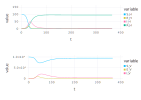

In [3]:
using Gadfly
fig1a = plot(mlt[mlt[:host] .== true,:], x=:t, y=:value, color=:variable, Geom.line)
fig1b = plot(mlt[mlt[:host] .!= true,:], x=:t, y=:value, color=:variable, Geom.line)
vstack(fig1a,fig1b)